# Quantization Aware Training with diff quant function
https://openaccess.thecvf.com/content_CVPR_2019/papers/Yang_Quantization_Networks_CVPR_2019_paper.pdf


https://github.com/aliyun/alibabacloud-quantization-networks/tree/master

## Imports

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Models

In [3]:
from quant.models import Net

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Examples :

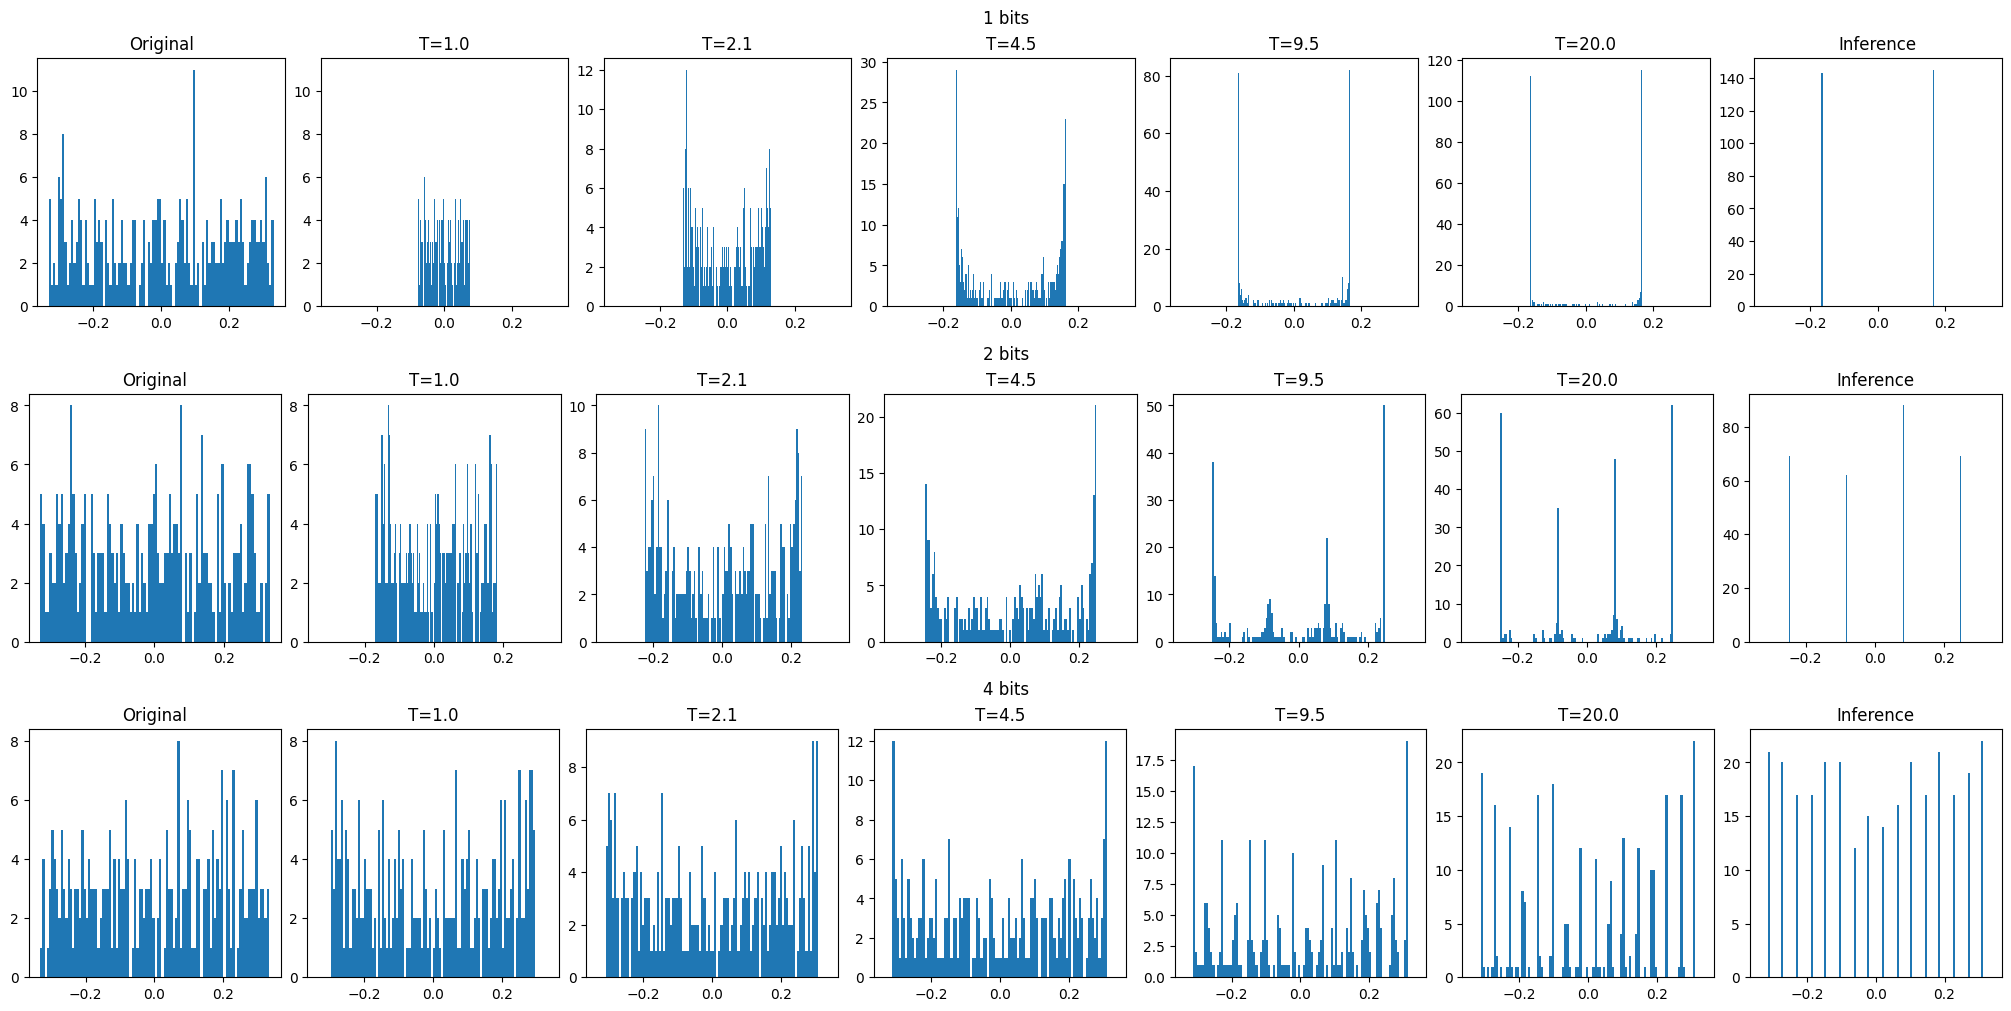

In [5]:
n_bits = [1, 2, 4]
Ts = np.geomspace(1, 20, 5)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
subfigs = fig.subfigures(len(n_bits), 1)
if len(n_bits) == 1:
    subfigs = [subfigs]

for n, subfig in zip(n_bits, subfigs):
    axs_v = subfig.subplots(1, len(Ts) + 2, sharex=True)
    subfig.suptitle(f"{n} bits")
    model = Net(quantization=True, n_bits=n)

    ax = axs_v[0]
    ax.hist(
        model.original_weights["conv1"].cpu().detach().numpy().flatten(),
        bins=100,
    )
    ax.set_title(f"Original")

    for T, ax in zip(Ts, axs_v[1:-1]):
        if model.quantization:
            model.set_temperature(T)
            model.set_training(True)
        ax.hist(
            model.modules_dict["conv1"].weight.cpu().detach().numpy().flatten(),
            bins=100,
        )
        ax.set_title(f"T={T:.1f}")

    model.set_training(False)
    ax = axs_v[-1]
    ax.hist(
        model.modules_dict["conv1"].weight.cpu().detach().numpy().flatten(), bins=100
    )
    ax.set_title(f"Inference")

## Training

In [6]:
from quant.training import train, test

### Data

In [69]:
batch_size = 64
test_batch_size = 1000

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

dataset = "MNIST"

if dataset == "MNIST":
    dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)
elif dataset == "CIFAR":

    dataset1 = datasets.CIFAR10(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.CIFAR10("../data", train=False, transform=transform)
else:
    raise ValueError("Data must be MNIST or CIFAR")

n_channels = {
    "MNIST": 1,
    "CIFAR": 3,
}
n_flatten = {"MNIST": 1600, "CIFAR": 2304}

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

### Init

In [135]:
from torch.nn.utils.parametrize import register_parametrization as rpm
import torch.nn as nn
from quant.models import QuantizedModel
import copy



In [150]:
n_bits = 5
quantize_activations = True

dropout = 0.2
original_model = Net(
    dropout=dropout, n_channels=n_channels[dataset], n_flatten=n_flatten[dataset]
).to(device)

q_model = QuantizedModel(original_model, n_bits=n_bits, quantize_activations=quantize_activations).to(device)

lr = 1e-3
gamma = 0.95

q_optimizer = optim.Adam(q_model.parameters(), lr=lr)
original_optimizer = optim.Adam(original_model.parameters(), lr=lr)

n_epochs = {"MNIST" : 5, "CIFAR" : 20}[dataset]

Ts = np.geomspace(1, 20, n_epochs * len(train_loader) + 1)
adjust_T = True

q_scheduler = StepLR(q_optimizer, step_size=1, gamma=gamma)
original_scheduler = StepLR(original_optimizer, step_size=1, gamma=gamma)

results = {
    "quantized": {
        "train_losses": [],
        "train_accs": [],
        "test_losses": [],
        "test_accs": [],
    },
    "original": {
        "train_losses": [],
        "train_accs": [],
        "test_losses": [],
        "test_accs": [],
    },
}

modules_dict.conv1
modules_dict.conv2
modules_dict.fc1
modules_dict.fc2


In [151]:
q_model.model

Net(
  (modules_dict): ModuleDict(
    (conv1): ParametrizedConv2d(
      1, 32, kernel_size=(3, 3), stride=(1, 1)
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): QuantizedModule(
            (quant): Quantization()
             (n_bits : 4)
             (alpha : 0.020768417045474052)
             (beta : 48.1500358581543)
             (T : 1.0)
          )
        )
      )
    )
    (relu1): ReLU()
    (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): ParametrizedConv2d(
      32, 64, kernel_size=(3, 3), stride=(1, 1)
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): QuantizedModule(
            (quant): Quantization()
             (n_bits : 4)
             (alpha : 0.003682442009449005)
             (beta : 271.5589294433594)
             (T : 1.0)
          )
        )
      )
    )
    (relu2): ReLU()
    (mp2): MaxPool2d(kernel_size=2, stride=2, paddi

In [137]:
q_model.set_training(False)
data, target = next(iter(train_loader))
data, target = data.to(device), target.to(device)
out = q_model(data)

### Train !

In [138]:
for model, optimizer, scheduler, name in zip(
    [q_model, original_model],
    [q_optimizer, original_optimizer],
    [q_scheduler, original_scheduler],
    ["quantized", "original"],
):

    pbar = tqdm(range(0, n_epochs + 1))

    for epoch in pbar:

        if epoch > 0:
            train_loss, train_acc, _ = train(
                model,
                device,
                train_loader,
                optimizer,
                epoch,
                pbar=None,
                Ts=Ts,
                adjust_T=adjust_T,
            )
            results[name]["train_losses"].extend(train_loss)
            results[name]["train_accs"].extend(train_acc)
            scheduler.step()

        test_loss, test_acc, _ = test(model, device, test_loader, pbar=pbar)
        results[name]["test_losses"].append(test_loss)
        results[name]["test_accs"].append(test_acc)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

### Results

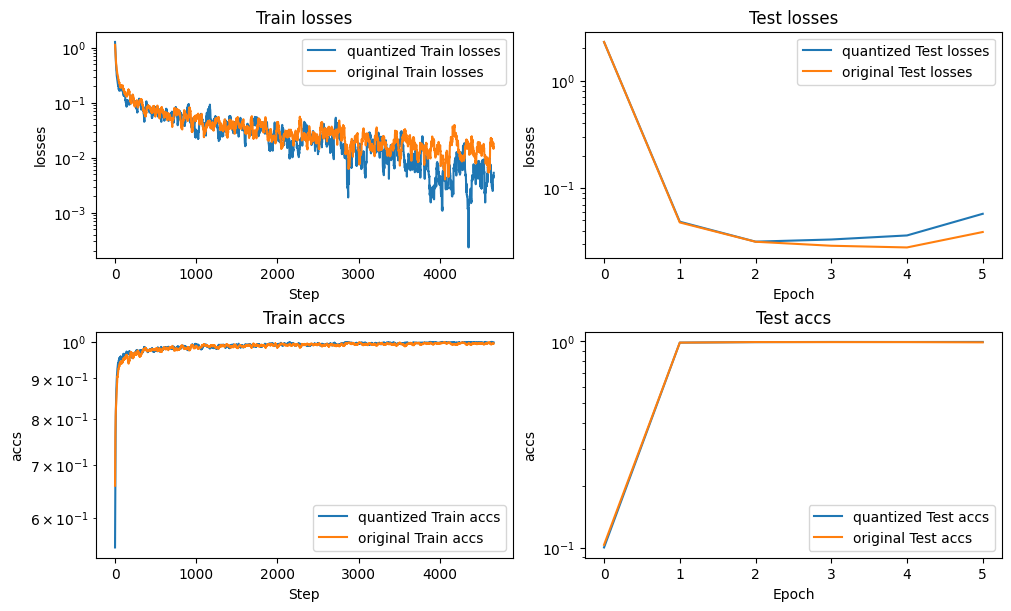

In [139]:
fig, axs = plt.subplots(
    2, 2, figsize=(10, 6), constrained_layout=True, sharex=False, sharey=False
)
for metric, axs_m in zip(["losses", "accs"], axs):
    for name in ["quantized", "original"]:
        for ax, trial in zip(axs_m, ["Train", "Test"]):

            res = results[name][f"{trial.lower()}_{metric}"]
            if trial == "Train":
                k = 25
                res = np.convolve(res, np.ones(k) / k, mode="valid")
            ax.plot(
                res,
                label=f"{name} {trial} {metric}",
            )
            ax.set_title(f"{trial} {metric}")
            ax.legend()
            ax.set_xlabel("Epoch" if trial == "Test" else "Step")
            ax.set_ylabel(metric)
            ax.set_yscale("log")
            # ax.set_xscale('log')

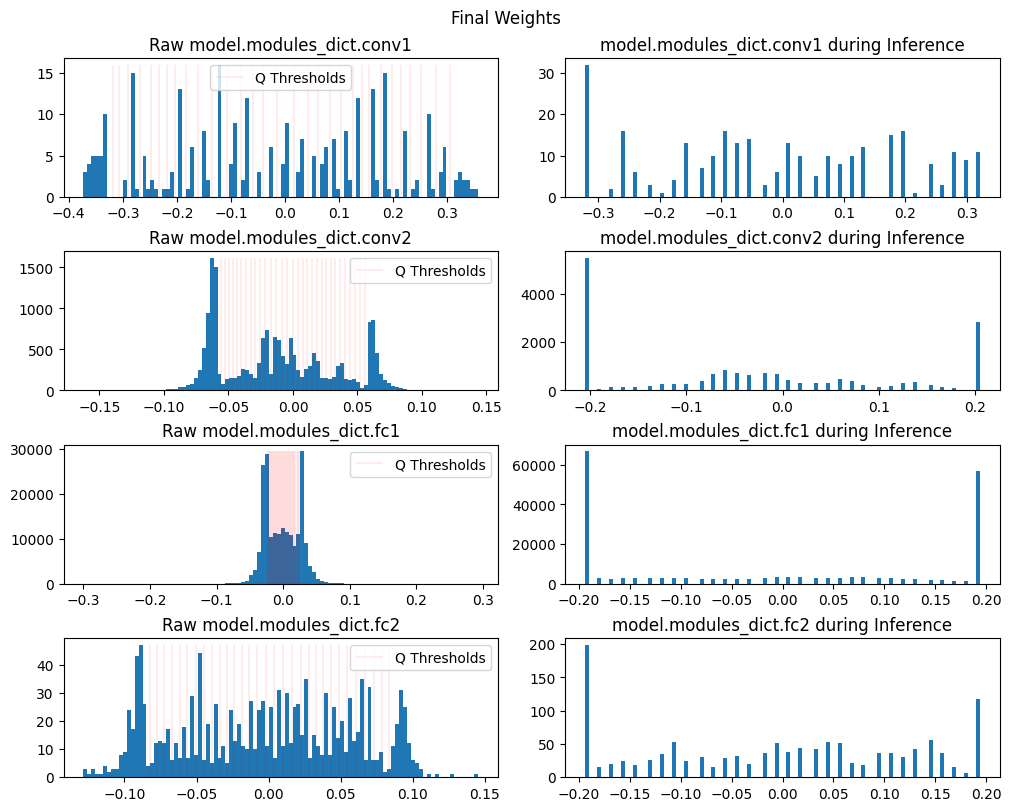

In [148]:
fig, axs = plt.subplots(
    q_model.n_layers, 2, constrained_layout=True, figsize=(10, 2 * q_model.n_layers)
)

for i, (axs_layer, (n, m)) in enumerate(
    zip(
        axs,
        {n: m for n, m in q_model.modules_dict.items() if hasattr(m, "weight")}.items(),
    )
):

    weights = m.weight.cpu().detach().numpy().flatten()

    ax = axs_layer[1]
    ax.hist(weights, bins=100)
    ax.set_title(f"{n} during Inference")

    ax = axs_layer[0]
    counts, *_ = ax.hist(
        q_model.original_weights[f"{n}"].cpu().detach().numpy().flatten(),
        bins=100,
    )
    ax.set_title(f"Raw {n}")
    ax.vlines(
        q_model.modules_dict[n]
        .parametrizations.weight[0]
        .quant.biases.cpu()
        .detach()
        .numpy()
        .flatten()
        / q_model.modules_dict[n]
        .parametrizations.weight[0]
        .quant.beta.cpu()
        .data.item(),
        0,
        max(counts),
        color="r",
        label="Q Thresholds",
        linewidth=0.1,
    )
    ax.legend()


fig.suptitle("Final Weights")
plt.show()